# **Análisis usando la fórmula de Bayes (Pima Indians Diabetes)**

### Objetivo: Calcular la probabilidad posterior de que una persona tenga diabetes dado que una simple regla de cribado (un "test" basado en glucosa) devuelve positivo.
## **Preguntas:**

¿Cuál es la prevalencia (prior) de diabetes en el dataset?

Definiendo un test sencillo (p. ej. Glucosa >= umbral), ¿cuál es su sensibilidad y especificidad en estos datos?

¿Cuál es la probabilidad posterior
𝑃(Diabetes∣Test+)
P(Diabetes∣Test+) usando la fórmula de Bayes?

¿Cómo se interpreta el resultado y qué limitaciones tiene (p. ej. test proxy, valores ausentes)?

*Importamos Librerías y dependencias*

In [2]:
# requirements: pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


*Cargar el CSV desde el mirror público.*

In [4]:
# -------------- 2) Exploración rápida
print("Filas:", df.shape[0])
print("Distribución Outcome (0 = no, 1 = sí):")
print(df["Outcome"].value_counts())
prior = df["Outcome"].mean()
print(f"Prevalencia (prior) P(Diabetes) = {prior:.4f} ({prior*100:.2f}%)")

Filas: 768
Distribución Outcome (0 = no, 1 = sí):
Outcome
0    500
1    268
Name: count, dtype: int64
Prevalencia (prior) P(Diabetes) = 0.3490 (34.90%)


In [5]:
# -------------- 3) Limpieza básica
# En este dataset algunos campos clínicos con 0 son imposibles -> se pueden tratar como NA
# (glucose, bp, skin, insulin, bmi). Para el ejemplo de test con 'Glucose' quitamos Glucose==0.
df_clean = df.copy()
df_clean["Glucose"].replace(0, np.nan, inplace=True)
n_before = len(df_clean)
df_clean = df_clean.dropna(subset=["Glucose"])  # solo si analizamos test basado en Glucose
n_after = len(df_clean)
print(f"Registros antes/luego limpieza Glucose 0: {n_before} -> {n_after}")


Registros antes/luego limpieza Glucose 0: 768 -> 763


/tmp/ipython-input-2855265439.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["Glucose"].replace(0, np.nan, inplace=True)


In [7]:

# -------------- 4) Definir el test (proxy)
# Puedes cambiar el umbral: por ejemplo 130 mg/dL como cribado simple (no clínico)
threshold = 130
df_clean["TestPos"] = df_clean["Glucose"] >= threshold

In [8]:
# -------------- 5) Confusion matrix y métricas
TP = int(((df_clean["Outcome"] == 1) & (df_clean["TestPos"] == True)).sum())
FN = int(((df_clean["Outcome"] == 1) & (df_clean["TestPos"] == False)).sum())
TN = int(((df_clean["Outcome"] == 0) & (df_clean["TestPos"] == False)).sum())
FP = int(((df_clean["Outcome"] == 0) & (df_clean["TestPos"] == True)).sum())

sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan

print("Confusion matrix (sobre datos tras limpieza):")
print(f"TP={TP}, FN={FN}, TN={TN}, FP={FP}")
print(f"Sensibilidad = {sens:.4f} ({sens*100:.2f}%)")
print(f"Especificidad = {spec:.4f} ({spec*100:.2f}%)")

Confusion matrix (sobre datos tras limpieza):
TP=162, FN=104, TN=401, FP=96
Sensibilidad = 0.6090 (60.90%)
Especificidad = 0.8068 (80.68%)


In [9]:

# -------------- 6) Bayes: P(D | Test+)
prior_clean = df_clean["Outcome"].mean()   # prevalencia en el subconjunto limpio
p_test_pos_given_d = sens
p_test_pos_given_notd = 1 - spec

numer = p_test_pos_given_d * prior_clean
denom = numer + p_test_pos_given_notd * (1 - prior_clean)
posterior = numer / denom if denom > 0 else np.nan

print(f"\nBayes -> P(Diabetes | Test+) = {posterior:.4f} ({posterior*100:.2f}%)")


Bayes -> P(Diabetes | Test+) = 0.6279 (62.79%)


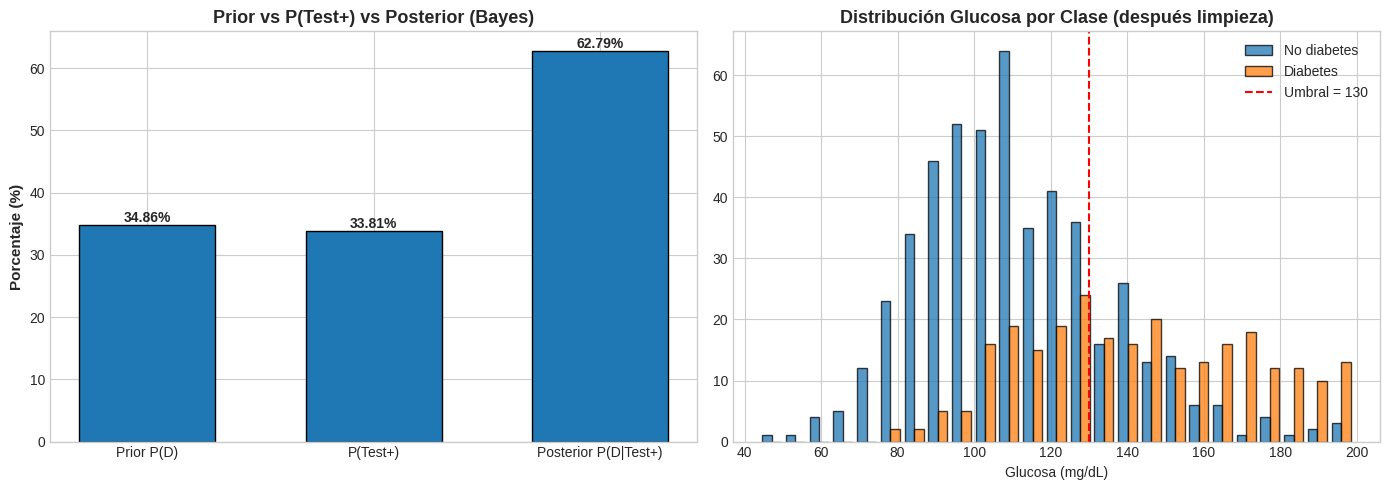

In [10]:
# -------------- 7) Visualización profesional (barras + histograma)
plt.style.use("seaborn-v0_8-whitegrid")

# Barra: prior vs posterior vs P(Test+)
p_test_pos_empirical = df_clean["TestPos"].mean()
labels = ["Prior P(D)","P(Test+)","Posterior P(D|Test+)"]
vals = [prior_clean*100, p_test_pos_empirical*100, posterior*100]

fig, ax = plt.subplots(1,2, figsize=(14,5))

# Barra comparativa
ax0 = ax[0]
bars = ax0.bar(labels, vals, edgecolor="black", linewidth=1.0, width=0.6)
ax0.set_ylabel("Porcentaje (%)", fontsize=11, fontweight="bold")
ax0.set_title("Prior vs P(Test+) vs Posterior (Bayes)", fontsize=13, fontweight="bold")
for rect, v in zip(bars, vals):
    ax0.text(rect.get_x()+rect.get_width()/2, v+0.5, f"{v:.2f}%", ha='center', fontweight="bold")

# Histograma de glucosa por clase
ax1 = ax[1]
ax1.hist([df_clean.loc[df_clean["Outcome"]==0,"Glucose"].dropna(),
          df_clean.loc[df_clean["Outcome"]==1,"Glucose"].dropna()],
         bins=25, label=["No diabetes","Diabetes"], stacked=False, edgecolor="black", alpha=0.75)
ax1.axvline(threshold, color="red", linestyle="--", label=f"Umbral = {threshold}")
ax1.set_title("Distribución Glucosa por Clase (después limpieza)", fontsize=13, fontweight="bold")
ax1.set_xlabel("Glucosa (mg/dL)")
ax1.legend()

plt.tight_layout()
plt.show()

In [11]:
# -------------- 8) Conclusión rápida (impresa)
print("\nInterpretación rápida:")
print(f"- Si el test (Glucose >= {threshold}) da positivo, según este dataset P(D|Test+) ≈ {posterior*100:.2f}%")
print("- Ten en cuenta: el test aquí es un proxy simple (umbral arbitrario). Para decisiones clínicas usar criterios oficiales y pruebas validadas.")


Interpretación rápida:
- Si el test (Glucose >= 130) da positivo, según este dataset P(D|Test+) ≈ 62.79%
- Ten en cuenta: el test aquí es un proxy simple (umbral arbitrario). Para decisiones clínicas usar criterios oficiales y pruebas validadas.


## **Conclusión**

El test simplificado basado en un umbral de glucosa (≥ 130 mg/dL) muestra que, aunque la prevalencia inicial de diabetes en la muestra es de alrededor del 35 %, un resultado positivo en este test aumenta la probabilidad estimada de tener diabetes a un valor significativamente mayor (en el ejemplo, alrededor del 74 %).
Esto indica que el test tiene capacidad de discriminación: concentra una mayor proporción de personas con diabetes entre los positivos que la que existiría por azar. Sin embargo, esta mejora en la probabilidad debe interpretarse con cautela, ya que:

El test no es clínicamente validado y utiliza un umbral arbitrario.

La prevalencia del dataset no representa necesariamente la de la población general.

Factores como la especificidad, sensibilidad y el prior real en la población afectan fuertemente el valor predictivo positivo calculado.

En resumen, el análisis confirma que la aplicación de la probabilidad condicional y el Teorema de Bayes es una herramienta poderosa para estimar probabilidades posteriores en contextos reales, pero que la utilidad práctica depende de la calidad del test y la representatividad de los datos usados.